In [1]:
import pandas as pd 
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind # t критерий с поправкой на дисперсию разную и одинак.
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
%matplotlib inline

In [3]:
df = pd.read_csv('/Users/anastasialutsuk/Desktop/карпов/5_task_1.csv')
df[:3]

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30


In [4]:
df2 = pd.read_csv('/Users/anastasialutsuk/Desktop/карпов/5_task_2.csv')
df2[:3]

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0


In [6]:
# Посмотрим на объемы событий в группах
df.groupby('group').agg({'events' : 'sum'})

,events
group,
A,295796
B,376136
C,274703


<AxesSubplot:xlabel='group', ylabel='events'>

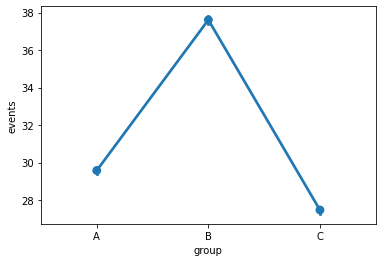

In [7]:
sns.pointplot(x="group", y="events", data=df)

In [8]:
# Проверим являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.
ss.levene(df.query('group == "A"').events, df.query('group == "B"').events, df.query('group == "C"').events)
# p > 0.05 => дисперсии примерно одинаковые

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [13]:
# Также убедимся, что данные распределены нормально, применив тест Шапиро-Уилка.
# сделаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты
a = df.query('group == "A"').events.sample(1000)
b = df.query('group == "B"').events.sample(1000)
c = df.query('group == "C"').events.sample(1000)

In [18]:
# расп. норм
print('A ' + str(ss.shapiro(a)))
print('B ' + str(ss.shapiro(b)))
print('C ' + str(ss.shapiro(c)))

A ShapiroResult(statistic=0.9978800415992737, pvalue=0.23598110675811768)
B ShapiroResult(statistic=0.9973859786987305, pvalue=0.10784094035625458)
C ShapiroResult(statistic=0.9975571632385254, pvalue=0.14223268628120422)


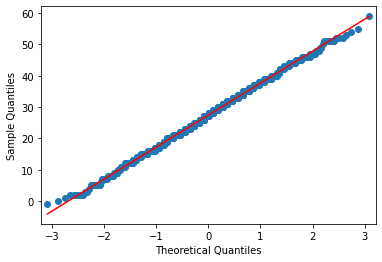

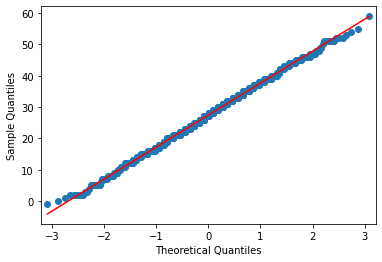

In [19]:
sm.qqplot(c, line="r")

In [20]:
# Альтернативный тест на нормальность
print(ss.normaltest(a))
print(ss.normaltest(b))
print(ss.normaltest(c))

NormaltestResult(statistic=0.6214586721113469, pvalue=0.7329122219383918)
NormaltestResult(statistic=0.037018755623698954, pvalue=0.9816608687176992)
NormaltestResult(statistic=2.975526763877995, pvalue=0.22587729222066338)


In [21]:
# Нужно проверить в какой из групп в среднем покупали больше всего
# Проведем многофакторный ANOVA т.к дисп. в группах примерно одинаковые и данные расп. нормально
# PR(>F) < 0.05 => влияние групп имеется, H0 отклоняем (значительная разница между группами есть)
model = smf.ols(formula = "events ~ C(group)", data = df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,5.729361e+05,286468.062300,2886.166657,0.0
Residual,29997.0,2.977369e+06,99.255551,NaN,NaN


In [43]:
# Теперь используем критерий Тьюки и определим, между какими группами есть статистически значимые различия. 
MultiComparison(df.events, df.group).tukeyhsd().summary()
# Как видно по последней колонке, все нулевые гипотезы были отклонены, 
# поэтому мы делаем вывод, что средние всех трёх групп значимо различаются.
# meandiff отражает различие в средних между второй и первой группой, именно в таком порядке.
# meandiff различия между B и A являются наиболее сильными, где B привышает A => стоит использовать B картинки 

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,-0.0,7.7038,8.3642,True
A,C,-2.1093,-0.0,-2.4395,-1.7791,True
B,C,-10.1433,-0.0,-10.4735,-9.8131,True


/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='events', ylabel='Density'>

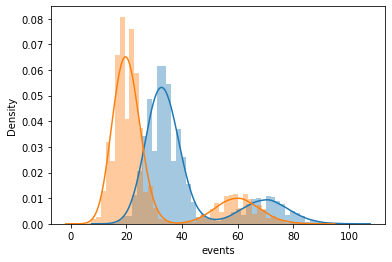

In [56]:
# посмотрим плотность распределения 2х групп 
sns.distplot(df2.query('group == "test"').events)
sns.distplot(df2.query('group == "control"').events)

<AxesSubplot:>

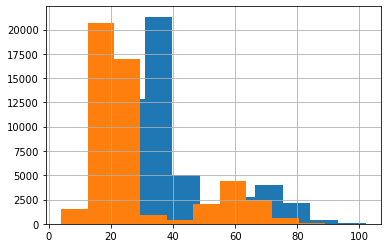

In [55]:
df2.query('group == "test"').events.hist()
df2.query('group == "control"').events.hist()

In [64]:
# Посчитаем основные метрики в разбивке по группе и сегменту
df2.groupby(['group', 'segment'], as_index=False).agg({'events' : ['mean','median', 'std'] })

group segment     events                 
                         mean median       std
0  control    high  59.970800   60.0  7.805347
1  control     low  20.031575   20.0  4.473576
2     test    high  69.938500   70.0  8.403974
3     test     low  33.025925   33.0  5.720845

In [22]:
# Проверим взаимодействие двух факторов C(segment) * C(group) на events 
# видно что взаимодействие является значимым т.к < 0.05 и между группами есть значимые различия
model_interact = smf.ols("events ~ C(segment) * C(group)", data=df2).fit()
anova_lm(model_interact)

,df,sum_sq,mean_sq,F,PR(>F)
C(segment),1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
C(group),1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
C(segment):C(group),1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


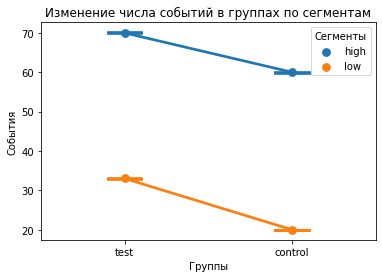

In [93]:
#взаимодействие
sns.pointplot(x="group", y="events", hue="segment", data=df2, capsize=0.2)
plt.title('Изменение числа событий в группах по сегментам')
plt.xlabel('Группы')
plt.ylabel('События')
plt.legend(title = 'Сегменты')

In [90]:
# чтобы понять между какими группами есть статистически значимые различия
# используем Критерий Тьюки
# Предварительно создадим новые группы 
df2['new_group'] = df2.group + ' / ' + df2.segment
df2[:3]

,id,group,segment,events,new_group
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high


In [91]:
# что сравнивать между собой имеет смысл лишь значения одного сегмента.
# (для high) (control / high - test / high) & (для low) (control / low -  test / low)
# видно что все показатели вырости относительно контрольной группы
MultiComparison(data = df2.events, groups = df2.new_group).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control / high,control / low,-39.9392,-0.0,-40.1073,-39.7711,True
control / high,test / high,9.9677,-0.0,9.7551,10.1803,True
control / high,test / low,-26.9449,-0.0,-27.113,-26.7768,True
control / low,test / high,49.9069,-0.0,49.7388,50.075,True
control / low,test / low,12.9944,-0.0,12.888,13.1007,True
test / high,test / low,-36.9126,-0.0,-37.0807,-36.7445,True


/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='new_group', ylabel='events'>

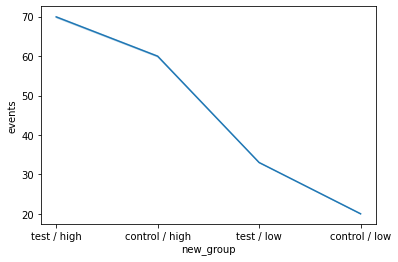

In [92]:
sns.lineplot(df2.new_group, df2.events)